In [338]:
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
import collections


In [339]:
def getGraphFromFile():
    graph = nx.read_edgelist('graph.txt', nodetype=int,
    data=(('weight',int),), create_using=nx.Graph())
    return graph

{(0, 1): Text(0.6406390460888342, -0.2466550849052066, '5'),
 (0, 2): Text(0.4968593933052816, -0.43558673519850416, '1'),
 (1, 2): Text(0.20272097832509856, -0.30265664981549495, '7'),
 (1, 3): Text(0.0031406066947183287, 0.058015482837176696, '4'),
 (2, 3): Text(-0.1406390460888342, -0.1309161674561209, '2'),
 (3, 4): Text(-0.6701097088596072, 0.49244923495960274, '3')}

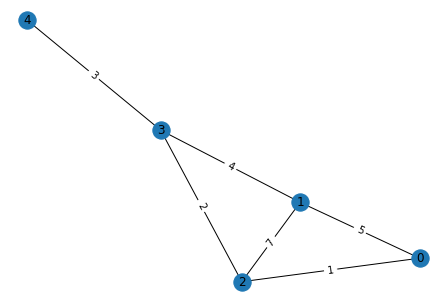

In [340]:
graph = getGraphFromFile()
pos = nx.spring_layout(graph)
nx.draw(graph,pos,with_labels=1)
labels = nx.get_edge_attributes(graph,'weight')
nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

In [341]:
qubitsNumber = graph.number_of_nodes()
layersNumber = 1
shotsNumber = 1000
device = qml.device("default.qubit", wires=qubitsNumber, shots=shotsNumber)

In [342]:
def U_b(beta):
    for qubit in range(qubitsNumber):
        qml.RX(2*beta, wires=qubit)

In [343]:
def U_c(gamma):
    for i,j in graph.edges():
        weight = graph.get_edge_data(i,j)['weight']
        qml.CNOT(wires=[i,j])
        qml.RZ(weight*gamma, wires = j)
        qml.CNOT(wires=[i,j])

In [344]:
def compBasisMeasurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [345]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z, requires_grad=False)

@qml.qnode(device)
def circuit(gammas, betas, edge=None):

    for i in range(0,qubitsNumber):
        qml.Hadamard(wires=i)

    for i in range(0,layersNumber):
        U_c(gammas[i])
        U_b(betas[i])

    if edge is None:
        return qml.sample(compBasisMeasurement(range(qubitsNumber)))

    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [346]:
def costFunction(params):
    gammas = params[0]
    betas = params[1]
    cost = 0
    for i,j in graph.edges():
        weight = graph.get_edge_data(i,j)['weight']
        cost -= 0.5*weight*(1-circuit(gammas, betas, edge=[i,j]))
    return cost

In [347]:
def getMaxCutSolution(params):
    gammas = params[0]
    betas = params[1]
    outputDecimal = circuit(gammas, betas)
    occurrences = collections.Counter(outputDecimal)
    return occurrences

In [348]:
def getOptimizer(optimizerName="GradientDescent", stepSize=0.01):
    if optimizerName == "GradientDescent":
        return qml.GradientDescentOptimizer(stepsize=stepSize)
    if optimizerName == "Adam":
        return qml.AdamOptimizer(stepsize=stepSize)
    if optimizerName == "NesterovMomentum":
        return qml.NesterovMomentumOptimizer(stepsize=stepSize)
    if optimizerName == "Adagrad":
        return qml.AdagradOptimizer(stepsize=stepSize)

In [349]:
if __name__ == '__main__':
    params = 0.01*np.random.rand(2, layersNumber)
    optimizer = getOptimizer(optimizerName="Adam", stepSize=0.3)
    stepNumber = 200
    for i in range(stepNumber):
        params = optimizer.step(costFunction, params)
    print("Final results: " + str(getMaxCutSolution(params)))

Results in 0 step: Counter({9.0: 110, 22.0: 95, 21.0: 88, 10.0: 86, 6.0: 62, 1.0: 52, 30.0: 51, 25.0: 44, 8.0: 41, 18.0: 41, 23.0: 37, 13.0: 32, 19.0: 22, 2.0: 22, 12.0: 22, 7.0: 20, 29.0: 18, 26.0: 17, 14.0: 16, 17.0: 16, 16.0: 14, 24.0: 14, 0.0: 14, 20.0: 13, 31.0: 12, 15.0: 10, 11.0: 7, 3.0: 7, 28.0: 6, 5.0: 6, 4.0: 5})
Results in 1 step: Counter({9.0: 118, 22.0: 105, 23.0: 79, 8.0: 78, 1.0: 77, 10.0: 71, 30.0: 64, 21.0: 59, 0.0: 47, 31.0: 37, 6.0: 24, 13.0: 24, 29.0: 23, 2.0: 22, 15.0: 20, 18.0: 19, 25.0: 18, 26.0: 16, 27.0: 14, 5.0: 13, 4.0: 13, 16.0: 13, 19.0: 7, 12.0: 6, 17.0: 6, 28.0: 5, 20.0: 5, 11.0: 4, 24.0: 4, 14.0: 3, 7.0: 3, 3.0: 3})
Results in 2 step: Counter({9.0: 48, 11.0: 46, 22.0: 41, 17.0: 38, 4.0: 38, 27.0: 38, 21.0: 38, 13.0: 38, 20.0: 37, 19.0: 36, 7.0: 35, 6.0: 34, 28.0: 34, 12.0: 33, 25.0: 32, 23.0: 31, 24.0: 31, 26.0: 30, 14.0: 30, 30.0: 29, 10.0: 28, 18.0: 28, 2.0: 27, 8.0: 26, 0.0: 26, 5.0: 25, 15.0: 25, 16.0: 23, 29.0: 22, 1.0: 18, 3.0: 18, 31.0: 17})
Resul

In [350]:
    drawer = qml.draw(circuit)
    print(drawer(params[0],params[1]))

 0: ──H──╭C─────────────╭C──╭C──────────────╭C───RX(0.935)──────────────────────────────────────────────────────────────────────────────────────────────────────╭┤ Sample[H0] 
 1: ──H──╰X──RZ(-2.28)──╰X──│───────────────│───╭C─────────────────────╭C──╭C─────────────╭C───RX(0.935)────────────────────────────────────────────────────────├┤ Sample[H0] 
 2: ──H─────────────────────╰X──RZ(-0.456)──╰X──╰X──────────RZ(-3.19)──╰X──│──────────────│───╭C──────────────────────╭C───RX(0.935)────────────────────────────├┤ Sample[H0] 
 3: ──H────────────────────────────────────────────────────────────────────╰X──RZ(-1.82)──╰X──╰X──────────RZ(-0.911)──╰X──╭C─────────────────────╭C──RX(0.935)──├┤ Sample[H0] 
 4: ──H───────────────────────────────────────────────────────────────────────────────────────────────────────────────────╰X──────────RZ(-1.37)──╰X──RX(0.935)──╰┤ Sample[H0] 
H0 =
[[ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ... 29  0  0]
 [ 0  0  0 ... 